# How to use the Targetome and Reactome BigQuery datasets
Check out other notebooks at our [Community Notebooks Repository](https://github.com/isb-cgc/Community-Notebooks)!

- **Title:** How to use the Targetome and Reactome BigQuery datasets
- **Author:** John Phan
- **Created:** 2021-07-23
- **Purpose:** Demonstrate basic usage of the Targetome and Reactome BigQuery datasets
- **URL:** https://github.com/isb-cgc/Community-Notebooks/blob/master/Notebooks/How_to_use_the_Targetome_and_Reactome_BQ_datasets.ipynb

This notebook demonstrates basic usage of the Targetome and Reactome BigQuery datasets. Joint analysis of these datasets can provide a powerful tool for identifying pathways affected by cancer drugs via known drug targets (i.e., genes or proteins).

The Cancer Targetome dataset is a curation of cancer drug and target (e.g., protein, RNA, DNA) interactions, supported by either experimental or literature evidence. More information about the Targetome study can be found here: https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5759325/. The original data can be found here: https://github.com/ablucher/The-Cancer-Targetome.

The Reactome is an open-source, manually curated, and peer-reviewed pathway database. More information can be found here: https://reactome.org/.

# Initialize Notebook Environment

Before running the analysis, we need to load depdnencies, authenticate to BigQuery, and customize notebook parameters.

## Import Dependencies

In [ ]:
# GCP Libraries
from google.cloud import bigquery
from google.colab import auth

# Data Analytics
import numpy as np
from scipy import stats

# Visualization
import matplotlib.pyplot as plt
import matplotlib
import seaborn as sns

## Authenticate

Before using BigQuery, we need to get authorization for access to BigQuery and the Google Cloud. For more information see ['Quick Start Guide to ISB-CGC'](https://isb-cancer-genomics-cloud.readthedocs.io/en/latest/sections/HowToGetStartedonISB-CGC.html). Alternative authentication methods can be found [here](https://googleapis.dev/python/google-api-core/latest/auth.html).

Alternatively, you can run this notebook in 'demo mode' using only a Google Account (i.e. a gmail account), not a billable Google Cloud Account. In 'demo mode', queries are sent to BigQuery via a CGC proxy, and a CGC account is charged for the queries. However the CGC proxy restricts which queries can be run, and the total amount of BigQuery processing volume (in GB) per user.

In [ ]:
demo_mode = True

if demo_mode:
    !wget -O collab_queries.py https://github.com/isb-cgc/Community-Notebooks/raw/refs/heads/master/BQProxy/collab_queries.py
    from collab_queries import api_endpoint, demo_client_args, demo_job_config_arg
else:
    # if you're using Google Colab, authenticate to gcloud with the following
    auth.authenticate_user()

    # alternatively, use the gcloud SDK
    #!gcloud auth application-default login

--2025-08-28 19:00:48--  https://github.com/isb-cgc/Community-Notebooks/raw/refs/heads/master/BQProxy/collab_queries.py
Resolving github.com (github.com)... 140.82.114.3
Connecting to github.com (github.com)|140.82.114.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/isb-cgc/Community-Notebooks/refs/heads/master/BQProxy/collab_queries.py [following]
--2025-08-28 19:00:48--  https://raw.githubusercontent.com/isb-cgc/Community-Notebooks/refs/heads/master/BQProxy/collab_queries.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 19980 (20K) [text/plain]
Saving to: ‘collab_queries.py’

collab_queries.py   100%[===================>]  19.51K  --.-KB/s    in 0.001s  

2025-08-28 19:00:48 (13.1 MB/s) -

## Parameters

Customize the following parameters based on your notebook, execution environment, or project.

In [ ]:
if demo_mode:
    google_project = "isb-cgc-dev-1"
else:
    # set the google project that will be billed for this notebook's computations
    google_project = 'isb-cgc-dev-1' ## Change me

## BigQuery Client

Create the BigQuery client.

In [ ]:
# Create a client to access the data within BigQuery
client_args = demo_client_args() if demo_mode else {}
client = bigquery.Client(google_project, **client_args)


# Targetome Analysis

## Identify Drugs Interacting w/ Target

The following query identifies all cancer drugs that have been found to interact with a specific target. In this example, the target is MS4A1, a gene that encodes a member of the membrane-spanning 4A gene family. Each identified drug is also associated with a literature evidence, identified by its PubMed ID.

In [ ]:
# set parameters for query
target_name = 'MS4A1' # target for which we want to identify drugs
# if using demo mode
demo_query_params= [bigquery.ScalarQueryParameter("target_name", "STRING", 'MS4A1')]
job_config_arg =  demo_job_config_arg(query_id="tr1", job_config=None, demo_query_params=demo_query_params) if demo_mode else {}

In [ ]:
# run query and put results in data frame
drug_interactions = client.query(("""
  SELECT
    inter.targetName,
    inter.drugName,
    src.PubMedID

  FROM
    `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter

  INNER JOIN `isb-cgc-bq.targetome_versioned.sources_v1` AS src
    -- link interactions to literature sources
    ON inter.sourceID = src.sourceID

  INNER JOIN `isb-cgc-bq.targetome_versioned.target_synonyms_v1` AS targsyn
    -- filter for interactions that match target
    ON inter.targetID = targsyn.targetID

  WHERE
    LOWER(targsyn.synonym) = LOWER('{target_name}')

  ORDER BY drugName ASC
""").format(
    target_name=target_name
), **job_config_arg).result().to_dataframe()

In [ ]:
# display result data frame
drug_interactions

,targetName,drugName,PubMedID
0,MS4A1,Ibritumomab Tiuxetan,NA_IUPHAR
1,MS4A1,Ibritumomab Tiuxetan,11752352
2,MS4A1,Ibritumomab Tiuxetan,12011122
3,MS4A1,Ibritumomab Tiuxetan,15045033
4,MS4A1,Ibritumomab Tiuxetan,20113680
5,MS4A1,Ibritumomab Tiuxetan,10541376
6,MS4A1,Ibritumomab Tiuxetan,11418316
7,MS4A1,Ibritumomab Tiuxetan,11879282
8,MS4A1,Obinutuzumab,23537278
9,MS4A1,Obinutuzumab,21378274


## Identify Interactions Supported by Experiments w/ Exact Binding Values

As reported in Blucher et al. (https://www.ncbi.nlm.nih.gov/pmc/articles/PMC5759325/) Figure 2, Level III Exact interactions refer to interactions annotated with exact (“=”) binding values reported, rather than “<” or “>”. There are approximately 2000 of these interactions. The following query identifies these interactions.

In [ ]:
# for demo_mode
job_config_arg =  demo_job_config_arg(query_id="tr2") if demo_mode else {}
# run query and put results in data frame
exact_interactions = client.query(("""
  SELECT
    DISTINCT
      inter.interactionID,
      inter.drugName,
      inter.targetName

  FROM
    `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter

  INNER JOIN `isb-cgc-bq.targetome_versioned.experiments_v1` AS exp
    -- filter for interactions with experiments
    ON inter.expID = exp.expID

  WHERE
    -- filter for exact binding evidence
    exp.exp_assayType IS NOT NULL
    AND exp.exp_assayRelation = '='

    -- filter for only human targets
    AND inter.targetSpecies = 'Homo sapiens'

  ORDER BY
    targetName ASC,
    drugName ASC
"""), **job_config_arg).result().to_dataframe()

In [ ]:
# display result data frame
exact_interactions

,interactionID,drugName,targetName
0,2130,Flutamide,AADAC
1,1921,Axitinib,AAK1
2,1538,Bosutinib,AAK1
3,1616,Crizotinib,AAK1
4,1061,Erlotinib Hydrochloride,AAK1
...,...,...,...
2023,865,Sorafenib Tosylate,ZAK
2024,866,Vandetanib,ZAK
2025,5936,Bosutinib,ZAP70
2026,6782,Ceritinib,ZAP70


## Experimental Evidence Supporting Target Binding for Imatinib

The Cancer Targetome database can help identify drugs with strong interactions supported by experimental data. Blucher et al. highlight the drub imatinib, a protein kinase inhibitor, as an example. Imatinib is involved in 87 interactions supported by experimental binding evidence under 100nM. The following query identifies all 87 interactions.

In [ ]:
# set parameters for query
drug_name = 'imatinib'
# if using demo mode
demo_query_params= [bigquery.ScalarQueryParameter("drug_name", "STRING", drug_name)]
job_config_arg =  demo_job_config_arg(query_id="tr3", job_config=None, demo_query_params=demo_query_params) if demo_mode else {}

In [ ]:
# run query and put results in data frame
drug_interactions = client.query(("""
 SELECT
    DISTINCT
      inter.* EXCEPT (sourceID),
      exp.exp_assayType,
      exp.exp_assayValueMedian

  FROM
    `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter

  INNER JOIN `isb-cgc-bq.targetome_versioned.experiments_v1` AS exp
    -- filter for interactions with experimental evidence
    ON inter.expID = exp.expID

  INNER JOIN `isb-cgc-bq.targetome_versioned.drug_synonyms_v1` AS drugsyn
    -- filter for interactions matching drug id
    ON inter.drugID = drugsyn.drugID

  WHERE
    -- filter by drug name
    LOWER(drugsyn.synonym) = LOWER('{drug_name}')

    -- make sure that all assay ranges are at or below 100nM
    AND exp.exp_assayValueMedian <= 100
    AND (exp.exp_assayValueLow <= 100 OR exp.exp_assayValueLow is null)
    AND (exp.exp_assayValueHigh <= 100 OR exp.exp_assayValueHigh is null)

    -- make sure the assay type is known (KD, Ki, IC50, or EC50)
    AND exp.exp_assayType IS NOT NULL
    AND exp.exp_assayRelation = '='

    -- limit to just experiments in humans
    AND inter.targetSpecies = 'Homo sapiens'

  ORDER BY inter.targetName ASC
""").format(
  drug_name=drug_name
), **job_config_arg).result().to_dataframe()

In [ ]:
# display result data frame
drug_interactions

,interactionID,drugID,targetID,interactionType,drugName,drug_approvalDate,drug_atcClassID,drug_atcClassName,drug_atcClassStatus,drug_epcClassID,drug_epcClassName,targetName,targetType,target_uniprotID,targetSpecies,expID,exp_assayType,exp_assayValueMedian
0,6,91,3,Inhibition,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,ABL1,Protein,P00519,Homo sapiens,1687,KD,2.2
1,6,91,3,Inhibition,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,ABL1,Protein,P00519,Homo sapiens,1691,KD,14.0
2,6,91,3,Inhibition,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,ABL1,Protein,P00519,Homo sapiens,1709,KD,44.0
3,6,91,3,Inhibition,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,ABL1,Protein,P00519,Homo sapiens,1722,KD,62.0
4,6,91,3,Inhibition,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,ABL1,Protein,P00519,Homo sapiens,1755,IC50,1.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
82,405,91,95,None,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,PDGFRB,Protein,P09619,Homo sapiens,5354,IC50,72.0
83,405,91,95,None,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,PDGFRB,Protein,P09619,Homo sapiens,9815,KD,14.0
84,405,91,95,None,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,PDGFRB,Protein,P09619,Homo sapiens,12275,KD,14.0
85,6742,91,841,None,Imatinib Mesylate,2001-05-10,L01XE,Protein kinase inhibitors,Approved,N0000175605,Kinase Inhibitor,SLC47A1,Protein,Q96FL8,Homo sapiens,14365,IC50,40.0


## Plot Histogram of Experimental Evidence for Imatinib Interactions

Figure 3A in Blucher et al. breaks down the interactions for imatinib by assay type (KD, Ki, IC50, and EC50). We can see that ABL1, the canonical target for imatinib, has low nanomolar assay evidence for all four assay types.

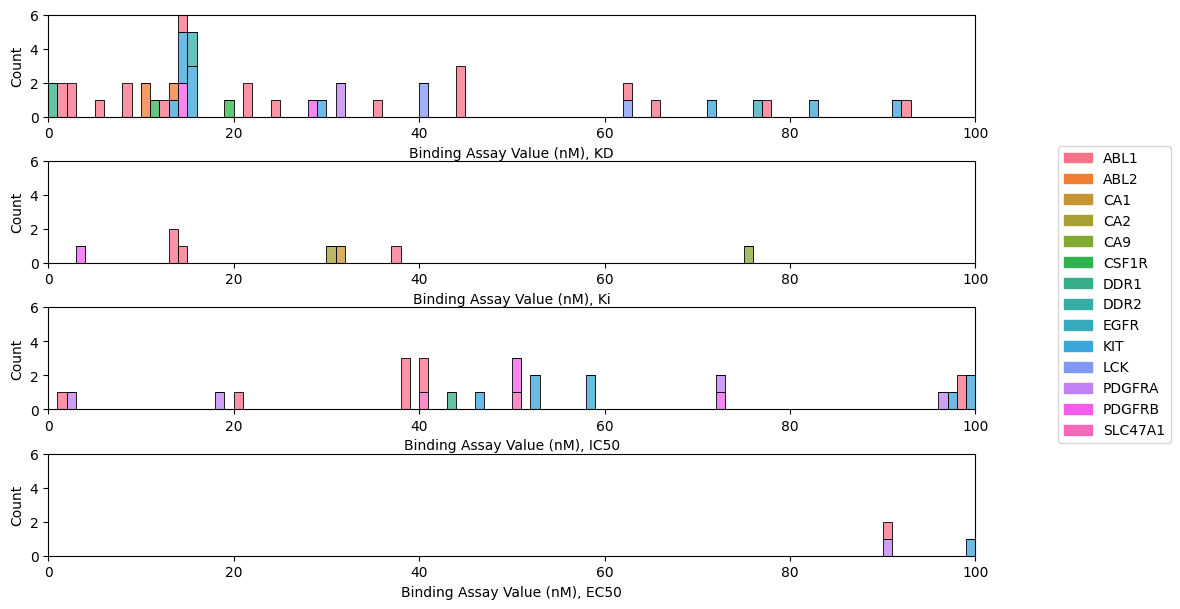

In [ ]:
# assign colors to each unique target to maintain
# legend consistency across subplots
sns_palette = sns.color_palette('husl', 14)
colors = {
  key: sns_palette[i] for i, key in enumerate(
    drug_interactions['targetName'].unique()
  )
}

# create a subplot with 4 rows and 1 column
fig, axes = plt.subplots(4, 1, figsize=(10, 6))
fig.tight_layout()

# plot KD data
KD_data = drug_interactions[
  (drug_interactions['exp_assayType']=='KD')
][['targetName', 'exp_assayValueMedian']]
sns.histplot(
  data=KD_data, ax=axes[0], x='exp_assayValueMedian', stat="count",
  hue='targetName', multiple="stack", bins=np.arange(0, 101, 1),
  palette=colors, element="bars", legend=False
)
axes[0].set_xlabel('Binding Assay Value (nM), KD')
axes[0].set_xlim([0,100])
axes[0].set_ylim([0,6])

# plot Ki data
Ki_data = drug_interactions[
  (drug_interactions['exp_assayType']=='Ki')
][['targetName', 'exp_assayValueMedian']]
sns.histplot(
  data=Ki_data, ax=axes[1], x='exp_assayValueMedian', stat="count",
  hue='targetName', multiple="stack", bins=np.arange(0, 101, 1),
  palette=colors, element="bars", legend=False
)
axes[1].set_xlabel('Binding Assay Value (nM), Ki')
axes[1].set_xlim([0,100])
axes[1].set_ylim([0,6])

# plot IC50 data
IC50_data = drug_interactions[
  (drug_interactions['exp_assayType']=='IC50')
][['targetName', 'exp_assayValueMedian']]
sns.histplot(
  data=IC50_data, ax=axes[2], x='exp_assayValueMedian', stat="count",
  hue='targetName', multiple="stack", bins=np.arange(0, 101, 1),
  palette=colors, element="bars", legend=False
)
axes[2].set_xlabel('Binding Assay Value (nM), IC50')
axes[2].set_xlim([0,100])
axes[2].set_ylim([0,6])

# plot EC50 data
EC50_data = drug_interactions[
  (drug_interactions['exp_assayType']=='EC50')
][['targetName', 'exp_assayValueMedian']]
sns.histplot(
  data=EC50_data, ax=axes[3], x='exp_assayValueMedian', stat="count",
  hue='targetName', multiple="stack", bins=np.arange(0, 101, 1),
  palette=colors, element="bars", legend=False
)
axes[3].set_xlabel('Binding Assay Value (nM), EC50')
axes[3].set_xlim([0,100])
axes[3].set_ylim([0,6])

# create a shared legend for all 4 subplots
patches = [
  matplotlib.patches.Patch(color=colors[key], label=key) for key in colors
]
fig.legend(handles=patches, loc='center left', bbox_to_anchor=(1.05, 0.5))

# Integrated Targetome and Reactome Analysis

## Identify all Reactome Pathways Targeted by Imatinib

We can join tables from the Reactome BigQuery dataset to identy all pathways targeted by Imatinib. Targetome UniProt IDs map to Reactome "physical entities", which can then be mapped to Reactome pathways. We further filter the physical entity to pathway evidence codes to retain only interactions that have "Traceable Author Statements" (TAS) rather than just "Inferred from Electronic Annotation" (IEA) to avoid evidence that have not been manually curated.

In [ ]:
# set parameters for query
drug_name = 'imatinib'
# if using demo mode
demo_query_params= [bigquery.ScalarQueryParameter("drug_name", "STRING", drug_name)]
job_config_arg =  demo_job_config_arg(query_id="tr4", job_config=None, demo_query_params=demo_query_params) if demo_mode else {}

In [ ]:
# run query and put results in data frame
drug_pathways = client.query(("""
  SELECT
    DISTINCT pathway.*

  FROM
    `isb-cgc-bq.reactome_versioned.pathway_v77` as pathway

  INNER JOIN `isb-cgc-bq.reactome_versioned.pe_to_pathway_v77` as pe2pathway
    -- link pathways to physical entities via intermediate table
    ON pathway.stable_id = pe2pathway.pathway_stable_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    -- link pathways to physical entities
    ON pe2pathway.pe_stable_id = pe.stable_id

  INNER JOIN `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter
    -- link physical entities to interactions
    ON pe.uniprot_id = inter.target_uniprotID

  INNER JOIN `isb-cgc-bq.targetome_versioned.experiments_v1` AS exp
    -- link interactions to experiments
    ON inter.expID = exp.expID

  INNER JOIN `isb-cgc-bq.targetome_versioned.drug_synonyms_v1` AS drugsyn
    -- filter for interactions matching drug id
    ON inter.drugID = drugsyn.drugID

  WHERE
    -- filter by drug name
    LOWER(drugsyn.synonym) = LOWER('{drug_name}')

    -- make sure that all assay ranges are at or below 100nM
    AND exp.exp_assayValueMedian <= 100
    AND (exp.exp_assayValueLow <= 100 OR exp.exp_assayValueLow is null)
    AND (exp.exp_assayValueHigh <= 100 OR exp.exp_assayValueHigh is null)

    -- make sure the assay type is known (KD, Ki, IC50, or EC50)
    AND exp.exp_assayType IS NOT NULL
    AND exp.exp_assayRelation = '='

    -- limit to just experiments in humans
    AND inter.targetSpecies = 'Homo sapiens'

    -- filter by stronger evidence: "Traceable Author Statement"
    AND pe2pathway.evidence_code = 'TAS'
  ORDER BY pathway.name ASC
""").format(
  drug_name=drug_name
), **job_config_arg).result().to_dataframe()

In [ ]:
# display result data frame
drug_pathways

,stable_id,url,name,species,lowest_level
0,R-HSA-1280218,https://reactome.org/PathwayBrowser/#/R-HSA-12...,Adaptive Immune System,Homo sapiens,False
1,R-HSA-422475,https://reactome.org/PathwayBrowser/#/R-HSA-42...,Axon guidance,Homo sapiens,False
2,R-HSA-389356,https://reactome.org/PathwayBrowser/#/R-HSA-38...,CD28 co-stimulation,Homo sapiens,False
3,R-HSA-389357,https://reactome.org/PathwayBrowser/#/R-HSA-38...,CD28 dependent PI3K/Akt signaling,Homo sapiens,True
4,R-HSA-389359,https://reactome.org/PathwayBrowser/#/R-HSA-38...,CD28 dependent Vav1 pathway,Homo sapiens,True
...,...,...,...,...,...
175,R-HSA-8864260,https://reactome.org/PathwayBrowser/#/R-HSA-88...,Transcriptional regulation by the AP-2 (TFAP2)...,Homo sapiens,False
176,R-HSA-202430,https://reactome.org/PathwayBrowser/#/R-HSA-20...,Translocation of ZAP-70 to Immunological synapse,Homo sapiens,True
177,R-HSA-425366,https://reactome.org/PathwayBrowser/#/R-HSA-42...,"Transport of bile salts and organic acids, met...",Homo sapiens,False
178,R-HSA-382551,https://reactome.org/PathwayBrowser/#/R-HSA-38...,Transport of small molecules,Homo sapiens,False


If we're only interested in the lowest level pathways, i.e., pathways that are not parents of other pathways in the hierarchy, we can filter by the "lowest_level" field in the pathways table.

In [ ]:
# if using demo mode
demo_query_params= [bigquery.ScalarQueryParameter("drug_name", "STRING", drug_name), bigquery.ArrayQueryParameter("lowest_level", "BOOL", [True]) ]
job_config_arg =  demo_job_config_arg(query_id="tr5", job_config=None, demo_query_params=demo_query_params) if demo_mode else {}
# run query and put results in data frame
drug_lowest_pathways = client.query(("""
  SELECT
    DISTINCT pathway.*

  FROM
    `isb-cgc-bq.reactome_versioned.pathway_v77` as pathway

  INNER JOIN `isb-cgc-bq.reactome_versioned.pe_to_pathway_v77` as pe2pathway
    -- link pathways to physical entities via intermediate table
    ON pathway.stable_id = pe2pathway.pathway_stable_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    -- link pathways to physical entities
    ON pe2pathway.pe_stable_id = pe.stable_id

  INNER JOIN `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter
    -- link physical entities to interactions
    ON pe.uniprot_id = inter.target_uniprotID

  INNER JOIN `isb-cgc-bq.targetome_versioned.experiments_v1` AS exp
    -- link interactions to experiments
    ON inter.expID = exp.expID

  INNER JOIN `isb-cgc-bq.targetome_versioned.drug_synonyms_v1` AS drugsyn
    -- filter for interactions matching drug id
    ON inter.drugID = drugsyn.drugID

  WHERE
    -- filter by drug name
    LOWER(drugsyn.synonym) = LOWER('{drug_name}')

    -- make sure that all assay ranges are at or below 100nM
    AND exp.exp_assayValueMedian <= 100
    AND (exp.exp_assayValueLow <= 100 OR exp.exp_assayValueLow is null)
    AND (exp.exp_assayValueHigh <= 100 OR exp.exp_assayValueHigh is null)

    -- make sure the assay type is known (KD, Ki, IC50, or EC50)
    AND exp.exp_assayType IS NOT NULL
    AND exp.exp_assayRelation = '='

    -- limit to just experiments in humans
    AND inter.targetSpecies = 'Homo sapiens'

    -- filter by stronger evidence: "Traceable Author Statement"
    AND pe2pathway.evidence_code = 'TAS'

    -- filter to include just lowest level pathways
    AND pathway.lowest_level = TRUE
  ORDER BY pathway.name ASC
""").format(
  drug_name=drug_name
), **job_config_arg).result().to_dataframe()

In [ ]:
# display data frame
drug_lowest_pathways

,stable_id,url,name,species,lowest_level
0,R-HSA-389357,https://reactome.org/PathwayBrowser/#/R-HSA-38...,CD28 dependent PI3K/Akt signaling,Homo sapiens,True
1,R-HSA-389359,https://reactome.org/PathwayBrowser/#/R-HSA-38...,CD28 dependent Vav1 pathway,Homo sapiens,True
2,R-HSA-389513,https://reactome.org/PathwayBrowser/#/R-HSA-38...,CTLA4 inhibitory signaling,Homo sapiens,True
3,R-HSA-8856825,https://reactome.org/PathwayBrowser/#/R-HSA-88...,Cargo recognition for clathrin-mediated endocy...,Homo sapiens,True
4,R-HSA-2219530,https://reactome.org/PathwayBrowser/#/R-HSA-22...,Constitutive Signaling by Aberrant PI3K in Cancer,Homo sapiens,True
...,...,...,...,...,...
75,R-HSA-9669934,https://reactome.org/PathwayBrowser/#/R-HSA-96...,Sunitinib-resistant KIT mutants,Homo sapiens,True
76,R-HSA-9674401,https://reactome.org/PathwayBrowser/#/R-HSA-96...,Sunitinib-resistant PDGFR mutants,Homo sapiens,True
77,R-HSA-8866910,https://reactome.org/PathwayBrowser/#/R-HSA-88...,TFAP2 (AP-2) family regulates transcription of...,Homo sapiens,True
78,R-HSA-8853884,https://reactome.org/PathwayBrowser/#/R-HSA-88...,Transcriptional Regulation by VENTX,Homo sapiens,True


## Pathway Enrichment Analysis
We can identify pathways that are "enriched" with the targets associated with a particular drug. In other words, we can answer the question: given a set of targets for a drug, which pathways contain those targets at a frequency higher than random chance? By calculating the probability that a number of target genes are contained in each pathway, we can identify pathways most likely to be targeted by the drug.

To do this, we can use a **chi-squared** test to determine if there is a statistically significant difference between the expected frequency of targets in a pathway compared to the observed frequency.


In [ ]:
# set query parameters
drug_name = 'sorafenib'
lowest_level = True # only show pathways at the lowest level

### Construct SQL Query

A single query can be used to calculate the chi-squared statistic for all pathways. This query is rather lengthy, but can be broken up into a series of sub-queries to create temporary tables. We step through each query below.

First, we write a query that simply gets a list of all targets of the drug:  

In [ ]:
target_list_query = """
  -- Table that contains a list of all distinct targets of the drug
  SELECT
    DISTINCT inter.target_uniprotID

  FROM
    `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter

  INNER JOIN `isb-cgc-bq.targetome_versioned.drug_synonyms_v1` AS drugsyn
    -- filter for interactions matching drug id
    ON inter.drugID = drugsyn.drugID

  INNER JOIN `isb-cgc-bq.targetome_versioned.experiments_v1` AS exp
    -- filter for interactions with experimental evidence
    ON inter.expID = exp.expID

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    -- filter for interactions with targets that match a reactome
    -- physical entity
    ON inter.target_uniprotID = pe.uniprot_id

  WHERE
    -- filter by drug name
    LOWER(drugsyn.synonym) = LOWER('{drug_name}')

    -- make sure that all assay ranges are at or below 100nM
    AND exp.exp_assayValueMedian <= 100
    AND (exp.exp_assayValueLow <= 100 OR exp.exp_assayValueLow is null)
    AND (exp.exp_assayValueHigh <= 100 OR exp.exp_assayValueHigh is null)

    -- make sure the assay type is known (KD, Ki, IC50, or EC50)
    AND exp.exp_assayType IS NOT NULL
    AND exp.exp_assayRelation = '='

    -- limit to just experiments in humans
    AND inter.targetSpecies = 'Homo sapiens'
""".format(
  drug_name=drug_name
).strip("\n")

In [ ]:
print(target_list_query)

  -- Table that contains a list of all distinct targets of the drug
  SELECT
    DISTINCT inter.target_uniprotID

  FROM
    `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter

  INNER JOIN `isb-cgc-bq.targetome_versioned.drug_synonyms_v1` AS drugsyn
    -- filter for interactions matching drug id
    ON inter.drugID = drugsyn.drugID

  INNER JOIN `isb-cgc-bq.targetome_versioned.experiments_v1` AS exp
    -- filter for interactions with experimental evidence
    ON inter.expID = exp.expID

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    -- filter for interactions with targets that match a reactome
    -- physical entity
    ON inter.target_uniprotID = pe.uniprot_id

  WHERE
    -- filter by drug name
    LOWER(drugsyn.synonym) = LOWER('sorafenib')

    -- make sure that all assay ranges are at or below 100nM
    AND exp.exp_assayValueMedian <= 100
    AND (exp.exp_assayValueLow <= 100 OR exp.exp_assayValueLow is null)
    AND (exp.exp_assayValueHigh <=

We then create a query that counts all targets associated with each Reactome pathway. This query depends on the previous "target_list_query" sub-query.

In [ ]:
target_pp_query = """
  -- Table that maps pathways to the total number of drug targets within that pathway
  SELECT
    COUNT(DISTINCT target_list_query.target_uniprotID) as num_targets,
    pathway.stable_id,
    pathway.name

  FROM
    target_list_query

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    -- filter for interactions with targets that match a reactome
    -- physical entity
    ON target_list_query.target_uniprotID = pe.uniprot_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pe_to_pathway_v77` AS pe2pathway
    -- link physical entities to pathways via intermediate table
    ON pe.stable_id = pe2pathway.pe_stable_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pathway_v77` AS pathway
    -- link physical entities to pathways
    ON pe2pathway.pathway_stable_id = pathway.stable_id

  WHERE
    -- filter by stronger evidence: "Traceable Author Statement"
    pe2pathway.evidence_code = 'TAS'

  GROUP BY pathway.stable_id, pathway.name
  ORDER BY num_targets DESC
""".format(
  drug_name=drug_name
).strip("\n")

In [ ]:
print(target_pp_query)

  -- Table that maps pathways to the total number of drug targets within that pathway
  SELECT
    COUNT(DISTINCT target_list_query.target_uniprotID) as num_targets,
    pathway.stable_id,
    pathway.name

  FROM
    target_list_query

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    -- filter for interactions with targets that match a reactome
    -- physical entity
    ON target_list_query.target_uniprotID = pe.uniprot_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pe_to_pathway_v77` AS pe2pathway
    -- link physical entities to pathways via intermediate table
    ON pe.stable_id = pe2pathway.pe_stable_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pathway_v77` AS pathway
    -- link physical entities to pathways
    ON pe2pathway.pathway_stable_id = pathway.stable_id

  WHERE
    -- filter by stronger evidence: "Traceable Author Statement"
    pe2pathway.evidence_code = 'TAS'

  GROUP BY pathway.stable_id, pathway.name
  ORDER BY num_targets DESC


Now we construct the same queries for proteins that are NOT targets of the drug. These are prefixed with "not_target". This query depends on the "target_list_query" sub-query.

In [ ]:
not_target_list_query = """
  -- Table that contains a list of all proteins that are NOT targets of the drug
  -- This query depends on "target_list_query", which is created by a previous
  -- query.
  SELECT
    DISTINCT inter.target_uniprotID AS target_uniprotID

  FROM `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter

  WHERE
    inter.targetSpecies = 'Homo sapiens'

    AND inter.target_uniprotID NOT IN (
      SELECT target_uniprotID FROM target_list_query
    )
""".strip("\n")

In [ ]:
print(not_target_list_query)

  -- Table that contains a list of all proteins that are NOT targets of the drug
  -- This query depends on "target_list_query", which is created by a previous
  -- query.
  SELECT
    DISTINCT inter.target_uniprotID AS target_uniprotID

  FROM `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter

  WHERE
    inter.targetSpecies = 'Homo sapiens'

    AND inter.target_uniprotID NOT IN (
      SELECT target_uniprotID FROM target_list_query
    )


In [ ]:
not_target_pp_query = """
  -- Table that maps pathways to the number of proteins that are NOT drug
  -- targets in that pathway.
  SELECT
    COUNT(DISTINCT not_target_list_query.target_uniprotID) AS num_not_targets,
    pathway.stable_id,
    pathway.name

  FROM not_target_list_query

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    ON not_target_list_query.target_uniprotID = pe.uniprot_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pe_to_pathway_v77` AS pe2pathway
    ON pe.stable_id = pe2pathway.pe_stable_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pathway_v77` AS pathway
    ON pe2pathway.pathway_stable_id = pathway.stable_id

  WHERE
    -- filter by stronger evidence: "Traceable Author Statement"
    pe2pathway.evidence_code = 'TAS'

  GROUP BY pathway.stable_id, pathway.name
  ORDER BY num_not_targets DESC
""".strip("\n")

In [ ]:
print(not_target_pp_query)

  -- Table that maps pathways to the number of proteins that are NOT drug
  -- targets in that pathway.
  SELECT
    COUNT(DISTINCT not_target_list_query.target_uniprotID) AS num_not_targets,
    pathway.stable_id,
    pathway.name

  FROM not_target_list_query

  INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
    ON not_target_list_query.target_uniprotID = pe.uniprot_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pe_to_pathway_v77` AS pe2pathway
    ON pe.stable_id = pe2pathway.pe_stable_id

  INNER JOIN `isb-cgc-bq.reactome_versioned.pathway_v77` AS pathway
    ON pe2pathway.pathway_stable_id = pathway.stable_id

  WHERE
    -- filter by stronger evidence: "Traceable Author Statement"
    pe2pathway.evidence_code = 'TAS'

  GROUP BY pathway.stable_id, pathway.name
  ORDER BY num_not_targets DESC


For convenience, we create a sub-query to keep the counts of the number of proteins that are targets and the number of proteins that are not targets.

In [ ]:
target_count_query = """
  -- Table that contains the counts of # of proteins that are/are not targets
  SELECT
    target_count,
    not_target_count,
    target_count + not_target_count AS total_count

  FROM
    (SELECT COUNT(*) AS target_count FROM target_list_query),
    (SELECT COUNT(*) AS not_target_count FROM not_target_list_query)
""".strip("\n")

Now we can create more interesting queries for the contingency matrices that contain the observed and expected values.

First, the observed contingency table counts for each pathway:

In [ ]:
observed_query = """
  -- Table with observed values per pathway in the contingency matrix
  SELECT
    target_pp_query.num_targets AS in_target_in_pathway,
    not_target_pp_query.num_not_targets AS not_target_in_pathway,
    target_count_query.target_count - target_pp_query.num_targets AS in_target_not_pathway,
    target_count_query.not_target_count - not_target_pp_query.num_not_targets AS not_target_not_pathway,
    target_pp_query.stable_id,
    target_pp_query.name

  FROM
    target_pp_query,
    target_count_query

  INNER JOIN not_target_pp_query
    ON target_pp_query.stable_id = not_target_pp_query.stable_id
""".strip("\n")

Then the observed row and column sums of the contingency table:

In [ ]:
sum_query = """
  -- Table with summed observed values per pathway in the contingency matrix
  SELECT
    observed_query.in_target_in_pathway + observed_query.not_target_in_pathway AS pathway_total,
    observed_query.in_target_not_pathway + observed_query.not_target_not_pathway AS not_pathway_total,
    observed_query.in_target_in_pathway + observed_query.in_target_not_pathway AS target_total,
    observed_query.not_target_in_pathway + observed_query.not_target_not_pathway AS not_target_total,
    observed_query.stable_id,
    observed_query.name

  FROM
    observed_query
""".strip("\n")

And the expected contingency table values for each pathway:

In [ ]:
expected_query = """
  -- Table with the expected values per pathway in the contingency matrix
  SELECT
    sum_query.target_total * sum_query.pathway_total / target_count_query.total_count AS exp_in_target_in_pathway,
    sum_query.not_target_total * sum_query.pathway_total / target_count_query.total_count AS exp_not_target_in_pathway,
    sum_query.target_total * sum_query.not_pathway_total / target_count_query.total_count AS exp_in_target_not_pathway,
    sum_query.not_target_total * sum_query.not_pathway_total / target_count_query.total_count AS exp_not_target_not_pathway,
    sum_query.stable_id,
    sum_query.name

  FROM
    sum_query, target_count_query
""".strip("\n")

Finally, we can calculate the chi-squared statistic for each pathway:

In [ ]:
chi_squared_query = """
  -- Table with the chi-squared statistic for each pathway
  SELECT
    -- Chi squared statistic with Yates' correction
    POW(ABS(observed_query.in_target_in_pathway - expected_query.exp_in_target_in_pathway) - 0.5, 2) / expected_query.exp_in_target_in_pathway
    + POW(ABS(observed_query.not_target_in_pathway - expected_query.exp_not_target_in_pathway) - 0.5, 2) / expected_query.exp_not_target_in_pathway
    + POW(ABS(observed_query.in_target_not_pathway - expected_query.exp_in_target_not_pathway) - 0.5, 2) / expected_query.exp_in_target_not_pathway
    + POW(ABS(observed_query.not_target_not_pathway - expected_query.exp_not_target_not_pathway) - 0.5, 2) / expected_query.exp_not_target_not_pathway
    AS chi_squared_stat,
    observed_query.stable_id,
    observed_query.name

  FROM observed_query

  INNER JOIN expected_query
    ON observed_query.stable_id = expected_query.stable_id
""".strip("\n")

The final query optionally adds a filter that removes all pathways that are not at the lowest level of the hierarchy. This helps remove non-specific "pathways" such as the generic "Disease" pathway.

In [ ]:
lowest_level_filter = """
  INNER JOIN `isb-cgc-bq.reactome_versioned.pathway_v77` AS pathway
    ON chi_squared_query.stable_id = pathway.stable_id

  WHERE pathway.lowest_level = TRUE
""".strip("\n")

In [ ]:
print(lowest_level_filter)

  INNER JOIN `isb-cgc-bq.reactome_versioned.pathway_v77` AS pathway
    ON chi_squared_query.stable_id = pathway.stable_id

  WHERE pathway.lowest_level = TRUE


Now we can combine all sub-queries into the final query:

In [ ]:
final_query = """
  WITH
    target_list_query AS (
      {target_list_query}
    ),

    target_pp_query AS (
      {target_pp_query}
    ),

    not_target_list_query AS (
      {not_target_list_query}
    ),

    not_target_pp_query AS (
      {not_target_pp_query}
    ),

    target_count_query AS (
      {target_count_query}
    ),

    observed_query AS (
      {observed_query}
    ),

    sum_query AS (
      {sum_query}
    ),

    expected_query AS (
      {expected_query}
    ),

    chi_squared_query AS (
      {chi_squared_query}
    )

  SELECT
    observed_query.in_target_in_pathway,
    observed_query.in_target_not_pathway,
    observed_query.not_target_in_pathway,
    observed_query.not_target_not_pathway,
    chi_squared_query.chi_squared_stat,
    chi_squared_query.stable_id,
    chi_squared_query.name

  FROM chi_squared_query

  INNER JOIN observed_query
    ON chi_squared_query.stable_id = observed_query.stable_id
  {lowest_level_filter}
  ORDER BY chi_squared_stat DESC
""".format(
  # make final query a little easier to read by removing/adding some white space
  target_list_query="\n    ".join(target_list_query.strip().splitlines()),
  target_pp_query="\n    ".join(target_pp_query.strip().splitlines()),
  not_target_list_query="\n    ".join(not_target_list_query.strip().splitlines()),
  not_target_pp_query="\n    ".join(not_target_pp_query.strip().splitlines()),
  target_count_query="\n    ".join(target_count_query.strip().splitlines()),
  observed_query="\n    ".join(observed_query.strip().splitlines()),
  sum_query="\n    ".join(sum_query.strip().splitlines()),
  expected_query="\n    ".join(expected_query.strip().splitlines()),
  chi_squared_query="\n    ".join(chi_squared_query.strip().splitlines()),
  lowest_level_filter=(
    "\n  "+"\n".join(lowest_level_filter.strip().splitlines())+"\n" if lowest_level else ""
  )
).strip("\n")

### Display Final Query

In [ ]:
# print the formatted final query
print(final_query)

  WITH
    target_list_query AS (
      -- Table that contains a list of all distinct targets of the drug
      SELECT
        DISTINCT inter.target_uniprotID
    
      FROM
        `isb-cgc-bq.targetome_versioned.interactions_v1` AS inter
    
      INNER JOIN `isb-cgc-bq.targetome_versioned.drug_synonyms_v1` AS drugsyn
        -- filter for interactions matching drug id
        ON inter.drugID = drugsyn.drugID
    
      INNER JOIN `isb-cgc-bq.targetome_versioned.experiments_v1` AS exp
        -- filter for interactions with experimental evidence
        ON inter.expID = exp.expID
    
      INNER JOIN `isb-cgc-bq.reactome_versioned.physical_entity_v77` AS pe
        -- filter for interactions with targets that match a reactome
        -- physical entity
        ON inter.target_uniprotID = pe.uniprot_id
    
      WHERE
        -- filter by drug name
        LOWER(drugsyn.synonym) = LOWER('sorafenib')
    
        -- make sure that all assay ranges are at or below 100nM
        AND 

### Execute the Query

Now execute the query to calculate a chi-squared statistic for each pathway:

In [ ]:
# if using demo mode
ll_param = [True] if lowest_level else [True, False, None]
demo_query_params= [bigquery.ScalarQueryParameter("drug_name", "STRING", drug_name), bigquery.ArrayQueryParameter("lowest_level", "BOOL", ll_param)]
job_config_arg =  demo_job_config_arg(query_id="tr6", job_config=None, demo_query_params=demo_query_params) if demo_mode else {}
# run query and put results in data frame

chi_squared_pathways = client.query(final_query, **job_config_arg).result().to_dataframe()

In [ ]:
# display the data frame
chi_squared_pathways

,in_target_in_pathway,in_target_not_pathway,not_target_in_pathway,not_target_not_pathway,chi_squared_stat,stable_id,name
0,3,18,3,678,31.192658,R-HSA-195399,VEGF binds to VEGFR leading to receptor dimeri...
1,2,19,1,680,22.942602,R-HSA-194306,Neurophilin interactions with VEGF and VEGFR
2,4,17,14,667,17.232611,R-HSA-2219530,Constitutive Signaling by Aberrant PI3K in Cancer
3,2,19,2,679,16.508319,R-HSA-525793,Myogenesis
4,2,19,4,677,10.101124,R-HSA-186763,Downstream signal transduction
...,...,...,...,...,...,...,...
62,1,20,12,669,0.033342,R-HSA-2894862,Constitutive Signaling by NOTCH1 HD+PEST Domai...
63,1,20,12,669,0.033342,R-HSA-2029482,Regulation of actin dynamics for phagocytic cu...
64,1,20,12,669,0.033342,R-HSA-9664422,FCGR3A-mediated phagocytosis
65,1,20,20,661,0.027803,R-HSA-8939236,RUNX1 regulates transcription of genes involve...


### Calculate P-Values

BigQuery does not have statistical functions to calculate p-values, so we use the SciPy stats library and update the data frame with a new p-value column:

In [ ]:
chi_squared_pathways['p_value'] = 1-stats.chi2.cdf(chi_squared_pathways['chi_squared_stat'], 1)
chi_squared_pathways

,in_target_in_pathway,in_target_not_pathway,not_target_in_pathway,not_target_not_pathway,chi_squared_stat,stable_id,name,p_value
0,3,18,3,678,31.192658,R-HSA-195399,VEGF binds to VEGFR leading to receptor dimeri...,2.336481e-08
1,2,19,1,680,22.942602,R-HSA-194306,Neurophilin interactions with VEGF and VEGFR,1.669114e-06
2,4,17,14,667,17.232611,R-HSA-2219530,Constitutive Signaling by Aberrant PI3K in Cancer,3.307106e-05
3,2,19,2,679,16.508319,R-HSA-525793,Myogenesis,4.843709e-05
4,2,19,4,677,10.101124,R-HSA-186763,Downstream signal transduction,1.481790e-03
...,...,...,...,...,...,...,...,...
62,1,20,12,669,0.033342,R-HSA-2894862,Constitutive Signaling by NOTCH1 HD+PEST Domai...,8.551126e-01
63,1,20,12,669,0.033342,R-HSA-2029482,Regulation of actin dynamics for phagocytic cu...,8.551126e-01
64,1,20,12,669,0.033342,R-HSA-9664422,FCGR3A-mediated phagocytosis,8.551126e-01
65,1,20,20,661,0.027803,R-HSA-8939236,RUNX1 regulates transcription of genes involve...,8.675732e-01


### Adjust for Multiple Testing

Since we're testing multiple pathways, we need to adjust the p-value threshold for significance accordingly. The number of pathways tested depends on whether or not we're considering all pathways, or just the lowest level pathways. That count can be obtained with the following query.

In [ ]:
# if using demo mode
ll_param = [True] if lowest_level else [True, False, None]
demo_query_params= [bigquery.ArrayQueryParameter("lowest_level", "BOOL", ll_param)]
job_config_arg =  demo_job_config_arg(query_id="tr7", job_config=None, demo_query_params=demo_query_params) if demo_mode else {}
# run query and put results in data frame
num_pathways_result = client.query(("""
  SELECT
    COUNT (*) AS num_pathways
  FROM
    `isb-cgc-bq.reactome_versioned.pathway_v77` as pathway
  {lowest_level_filter}
""").format(
  lowest_level_filter=("WHERE lowest_level = TRUE" if lowest_level else "")
), **job_config_arg).result().to_dataframe()

In [ ]:
print("""
  SELECT
    COUNT (*) AS num_pathways
  FROM
    `isb-cgc-bq.reactome_versioned.pathway_v77` as pathway
  {lowest_level_filter}
""").format(
  lowest_level_filter=("WHERE lowest_level = TRUE" if lowest_level else ""))


  SELECT
    COUNT (*) AS num_pathways
  FROM
    `isb-cgc-bq.reactome_versioned.pathway_v77` as pathway
  {lowest_level_filter}



AttributeError: 'NoneType' object has no attribute 'format'

In [ ]:
# display data frame
num_pathways_result

,num_pathways
0,1773


In [ ]:
# adjust significance threshold for multiple testing, using a p-value of 0.01
num_pathways = num_pathways_result['num_pathways'][0]
significance_threshold = 0.01/num_pathways
print('Significance Threshold: {}'.format(significance_threshold))

# find all pathways that meet the significance criteria after adjusting for
# multiple testing
significant_pathway_index = chi_squared_pathways['p_value']<significance_threshold

# list of significant pathways
significant_pathways = chi_squared_pathways[significant_pathway_index]

Significance Threshold: 5.640157924421884e-06


The final result is a list of all pathways in which the targeted proteins are enriched, or over-represented, at a rate higher than random chance.

In [ ]:
# display the final data frame
significant_pathways

,in_target_in_pathway,in_target_not_pathway,not_target_in_pathway,not_target_not_pathway,chi_squared_stat,stable_id,name,p_value
0,3,18,3,678,31.192658,R-HSA-195399,VEGF binds to VEGFR leading to receptor dimeri...,2.336481e-08
1,2,19,1,680,22.942602,R-HSA-194306,Neurophilin interactions with VEGF and VEGFR,1.669114e-06


The results of this analysis suggest that at least two pathways may be affected by the drug sorafenib, based on the known targets of the sorafenib.

### Verify Results by Comparing to SciPy Chi-Squared Function

We verify these BigQuery results by calculating the same chi-squared statistic using the SciPy package. Comparing the SciPy p-values and statistics to those of the BigQuery-derived results confirms that they are identical.

In [ ]:
# extract observed values from bigquery result
observed = chi_squared_pathways[[
  'in_target_in_pathway',
  'in_target_not_pathway',
  'not_target_in_pathway',
  'not_target_not_pathway'
]]

# calculate the chi-squared statistic using the scipy stats package
chi2_stat = []
chi2_pvalue = []
for index, row in observed.iterrows():
  stat, pvalue, _, _ = stats.chi2_contingency(
    np.reshape(np.matrix(row), (2,2)), correction=True
  )
  chi2_stat.append(stat)
  chi2_pvalue.append(pvalue)

# add columns to the original data frame
chi_squared_pathways['scipy_stat'] = chi2_stat
chi_squared_pathways['scipy_p_value'] = chi2_pvalue

AttributeError: 'numpy.dtypes.ObjectDType' object has no attribute 'dtype'

In [ ]:
# display the updated data frame
chi_squared_pathways

,in_target_in_pathway,in_target_not_pathway,not_target_in_pathway,not_target_not_pathway,chi_squared_stat,stable_id,name,p_value
0,3,18,3,678,31.192658,R-HSA-195399,VEGF binds to VEGFR leading to receptor dimeri...,2.336481e-08
1,2,19,1,680,22.942602,R-HSA-194306,Neurophilin interactions with VEGF and VEGFR,1.669114e-06
2,4,17,14,667,17.232611,R-HSA-2219530,Constitutive Signaling by Aberrant PI3K in Cancer,3.307106e-05
3,2,19,2,679,16.508319,R-HSA-525793,Myogenesis,4.843709e-05
4,2,19,4,677,10.101124,R-HSA-186763,Downstream signal transduction,1.481790e-03
...,...,...,...,...,...,...,...,...
62,1,20,12,669,0.033342,R-HSA-2894862,Constitutive Signaling by NOTCH1 HD+PEST Domai...,8.551126e-01
63,1,20,12,669,0.033342,R-HSA-2029482,Regulation of actin dynamics for phagocytic cu...,8.551126e-01
64,1,20,12,669,0.033342,R-HSA-9664422,FCGR3A-mediated phagocytosis,8.551126e-01
65,1,20,20,661,0.027803,R-HSA-8939236,RUNX1 regulates transcription of genes involve...,8.675732e-01


# Conclusion

This notebook demonstrated an integrated analysis of the Targetome and Reactome BigQuery datasets for identification of drug targets, identification of cancer pathways targeted by a drug, and pathway enrichment analysis using a chi-squared statistic.